In [ ]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
ROOT_DIR = r'/Users/abhay/Desktop/Surajit-2025/Dataset/DATASET/kaggle_3m'


In [ ]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install visualkeras


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# -*- coding: utf-8 -*-
import os
import re
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     concatenate, Activation, Add, multiply)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

print("TF version:", tf.__version__)


2025-08-16 12:26:00.544614: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 12:26:00.561237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755327360.579856   12154 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755327360.585685   12154 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755327360.599940   12154 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TF version: 2.19.0


In [ ]:
# Example Windows path:
root_dir = r"/home/surajit/Surajit-Dataset/kaggle_3m"


In [ ]:
TARGET_SIZE = (256, 256)   # will resize images & masks
COLOR_MODE  = 'grayscale'  # set to 'rgb' if your TIFFs are RGB
BATCH_SIZE  = 16
EPOCHS      = 100
VAL_PATIENCE = 25
LR          = 1e-4

# If your masks are soft (not strictly 0/255), you can hard-binarize:
HARD_BINARIZE_MASKS = False  # set True if needed

# -----------------------------
# Data loading helpers
# -----------------------------
def load_preprocess_image(img_path, target_size=TARGET_SIZE, color_mode=COLOR_MODE):
    img = load_img(img_path, color_mode=color_mode, target_size=target_size)
    img = img_to_array(img).astype("float32") / 255.0
    # Ensure channels-last with correct depth
    if color_mode == 'grayscale':
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        elif img.shape[-1] != 1:
            img = img[..., :1]
    return img

def load_preprocess_mask(mask_path, target_size=TARGET_SIZE):
    m = load_img(mask_path, color_mode='grayscale', target_size=target_size)
    m = img_to_array(m).astype("float32") / 255.0
    if HARD_BINARIZE_MASKS:
        m = (m > 0.5).astype("float32")
    return m

def load_dataset_recursive_mask_suffix(root_dir):
    """
    Recursively loads all .tif/.tiff, pairing files with `_mask` suffix as masks.
    Example pair:
      TCGA_CS_..._4.tif       -> image
      TCGA_CS_..._4_mask.tif  -> mask
    """
    X, y = [], []
    tif_files = glob.glob(os.path.join(root_dir, "**", "*.tif"), recursive=True) + \
                glob.glob(os.path.join(root_dir, "**", "*.tiff"), recursive=True)

    # Build dicts keyed by the base name (without _mask and extension)
    images = {}
    masks  = {}
    for f in tif_files:
        name = os.path.basename(f)
        base, ext = os.path.splitext(name)
        if base.endswith("_mask"):
            key = base[:-5]  # strip "_mask"
            masks[key] = f
        else:
            images[base] = f

    matched = 0
    for key, img_path in images.items():
        if key in masks:
            mask_path = masks[key]
            try:
                img  = load_preprocess_image(img_path)
                mask = load_preprocess_mask(mask_path)
                if img.shape[:2] != mask.shape[:2]:
                    # resize already done via target_size
                    pass
                X.append(img); y.append(mask)
                matched += 1
            except Exception as e:
                print(f"[ERROR] Failed pair:\n  IMG: {img_path}\n  MSK: {mask_path}\n  Reason: {e}")
        else:
            # If you expect every image to have a mask, keep this warning:
            print(f"[WARN] No mask for: {img_path}")

    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="float32")
    print(f"Loaded {matched} image–mask pairs.")
    return X, y

In [ ]:
# Dice Score Function
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
# Attention block
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, kernel_size=1, strides=1, padding='same')(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = multiply([x, rate])
    return att_x

# Residual block with 1x1 convolution to match dimensions
def residual_block(x, filters):
    res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    res = Activation('relu')(res)
    res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(res)

    # 1x1 convolution to match the dimensions of res
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)

    res = Add()([res, x])
    res = Activation('relu')(res)
    return res

def unet_attention_residual(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = residual_block(pool4, 1024)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    att6 = attention_block(conv4, up6, 512)
    merge6 = concatenate([att6, up6], axis=3)
    conv6 = residual_block(merge6, 512)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    att7 = attention_block(conv3, up7, 256)
    merge7 = concatenate([att7, up7], axis=3)
    conv7 = residual_block(merge7, 256)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    att8 = attention_block(conv2, up8, 128)
    merge8 = concatenate([att8, up8], axis=3)
    conv8 = residual_block(merge8, 128)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    att9 = attention_block(conv1, up9, 64)
    merge9 = concatenate([att9, up9], axis=3)
    conv9 = residual_block(merge9, 64)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
X, y = load_dataset_recursive_mask_suffix(root_dir)
assert len(X) == len(y) and len(X) > 0, "No image–mask pairs found. Check ROOT_DIR and naming."

# -----------------------------
# Split
# -----------------------------
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val,   X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=42)
print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")




Loaded 3929 image–mask pairs.
Train/Val/Test sizes: 2750 / 589 / 590


In [ ]:
in_channels = 1 if COLOR_MODE == 'grayscale' else 3

In [ ]:
# Define model
model = unet_attention_residual(input_size=(256, 256, 1))

2025-08-16 12:26:08.474338: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ add_1[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_6[0][0]  

 Total params: 33,125,445 (126.36 MB)

 Trainable params: 33,125,445 (126.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define model
model = unet_attention_residual(input_size=(256, 256, 1))

# Callbacks (optional)
checkpoint = ModelCheckpoint('best_model2k.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)


In [ ]:
# Measure training time
start_time = time.time()

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50


2025-08-16 12:26:20.035602: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


344/344 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.9823 - loss: 0.1193 - val_accuracy: 0.9906 - val_loss: 0.0333
Epoch 2/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.9893 - loss: 0.0377 - val_accuracy: 0.9906 - val_loss: 0.0310
Epoch 3/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.9896 - loss: 0.0345 - val_accuracy: 0.9921 - val_loss: 0.0259
Epoch 4/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.9915 - loss: 0.0275 - val_accuracy: 0.9924 - val_loss: 0.0271
Epoch 5/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.9915 - loss: 0.0262 - val_accuracy: 0.9942 - val_loss: 0.0195
Epoch 6/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 669s 2s/step - accuracy: 0.9936 - loss: 0.0194 - val_accuracy: 0.9939 - val_loss: 0.0164
Epoch 7/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.9946 - loss: 0.0149 - val_accuracy: 0.9958 - val_loss: 0.0126
Epoch 8/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.9957 - loss: 0.0117 - val_accuracy: 0.995

In [ ]:
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total Training Time: {total_training_time} seconds")

Total Training Time: 14644.504351139069 seconds


19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


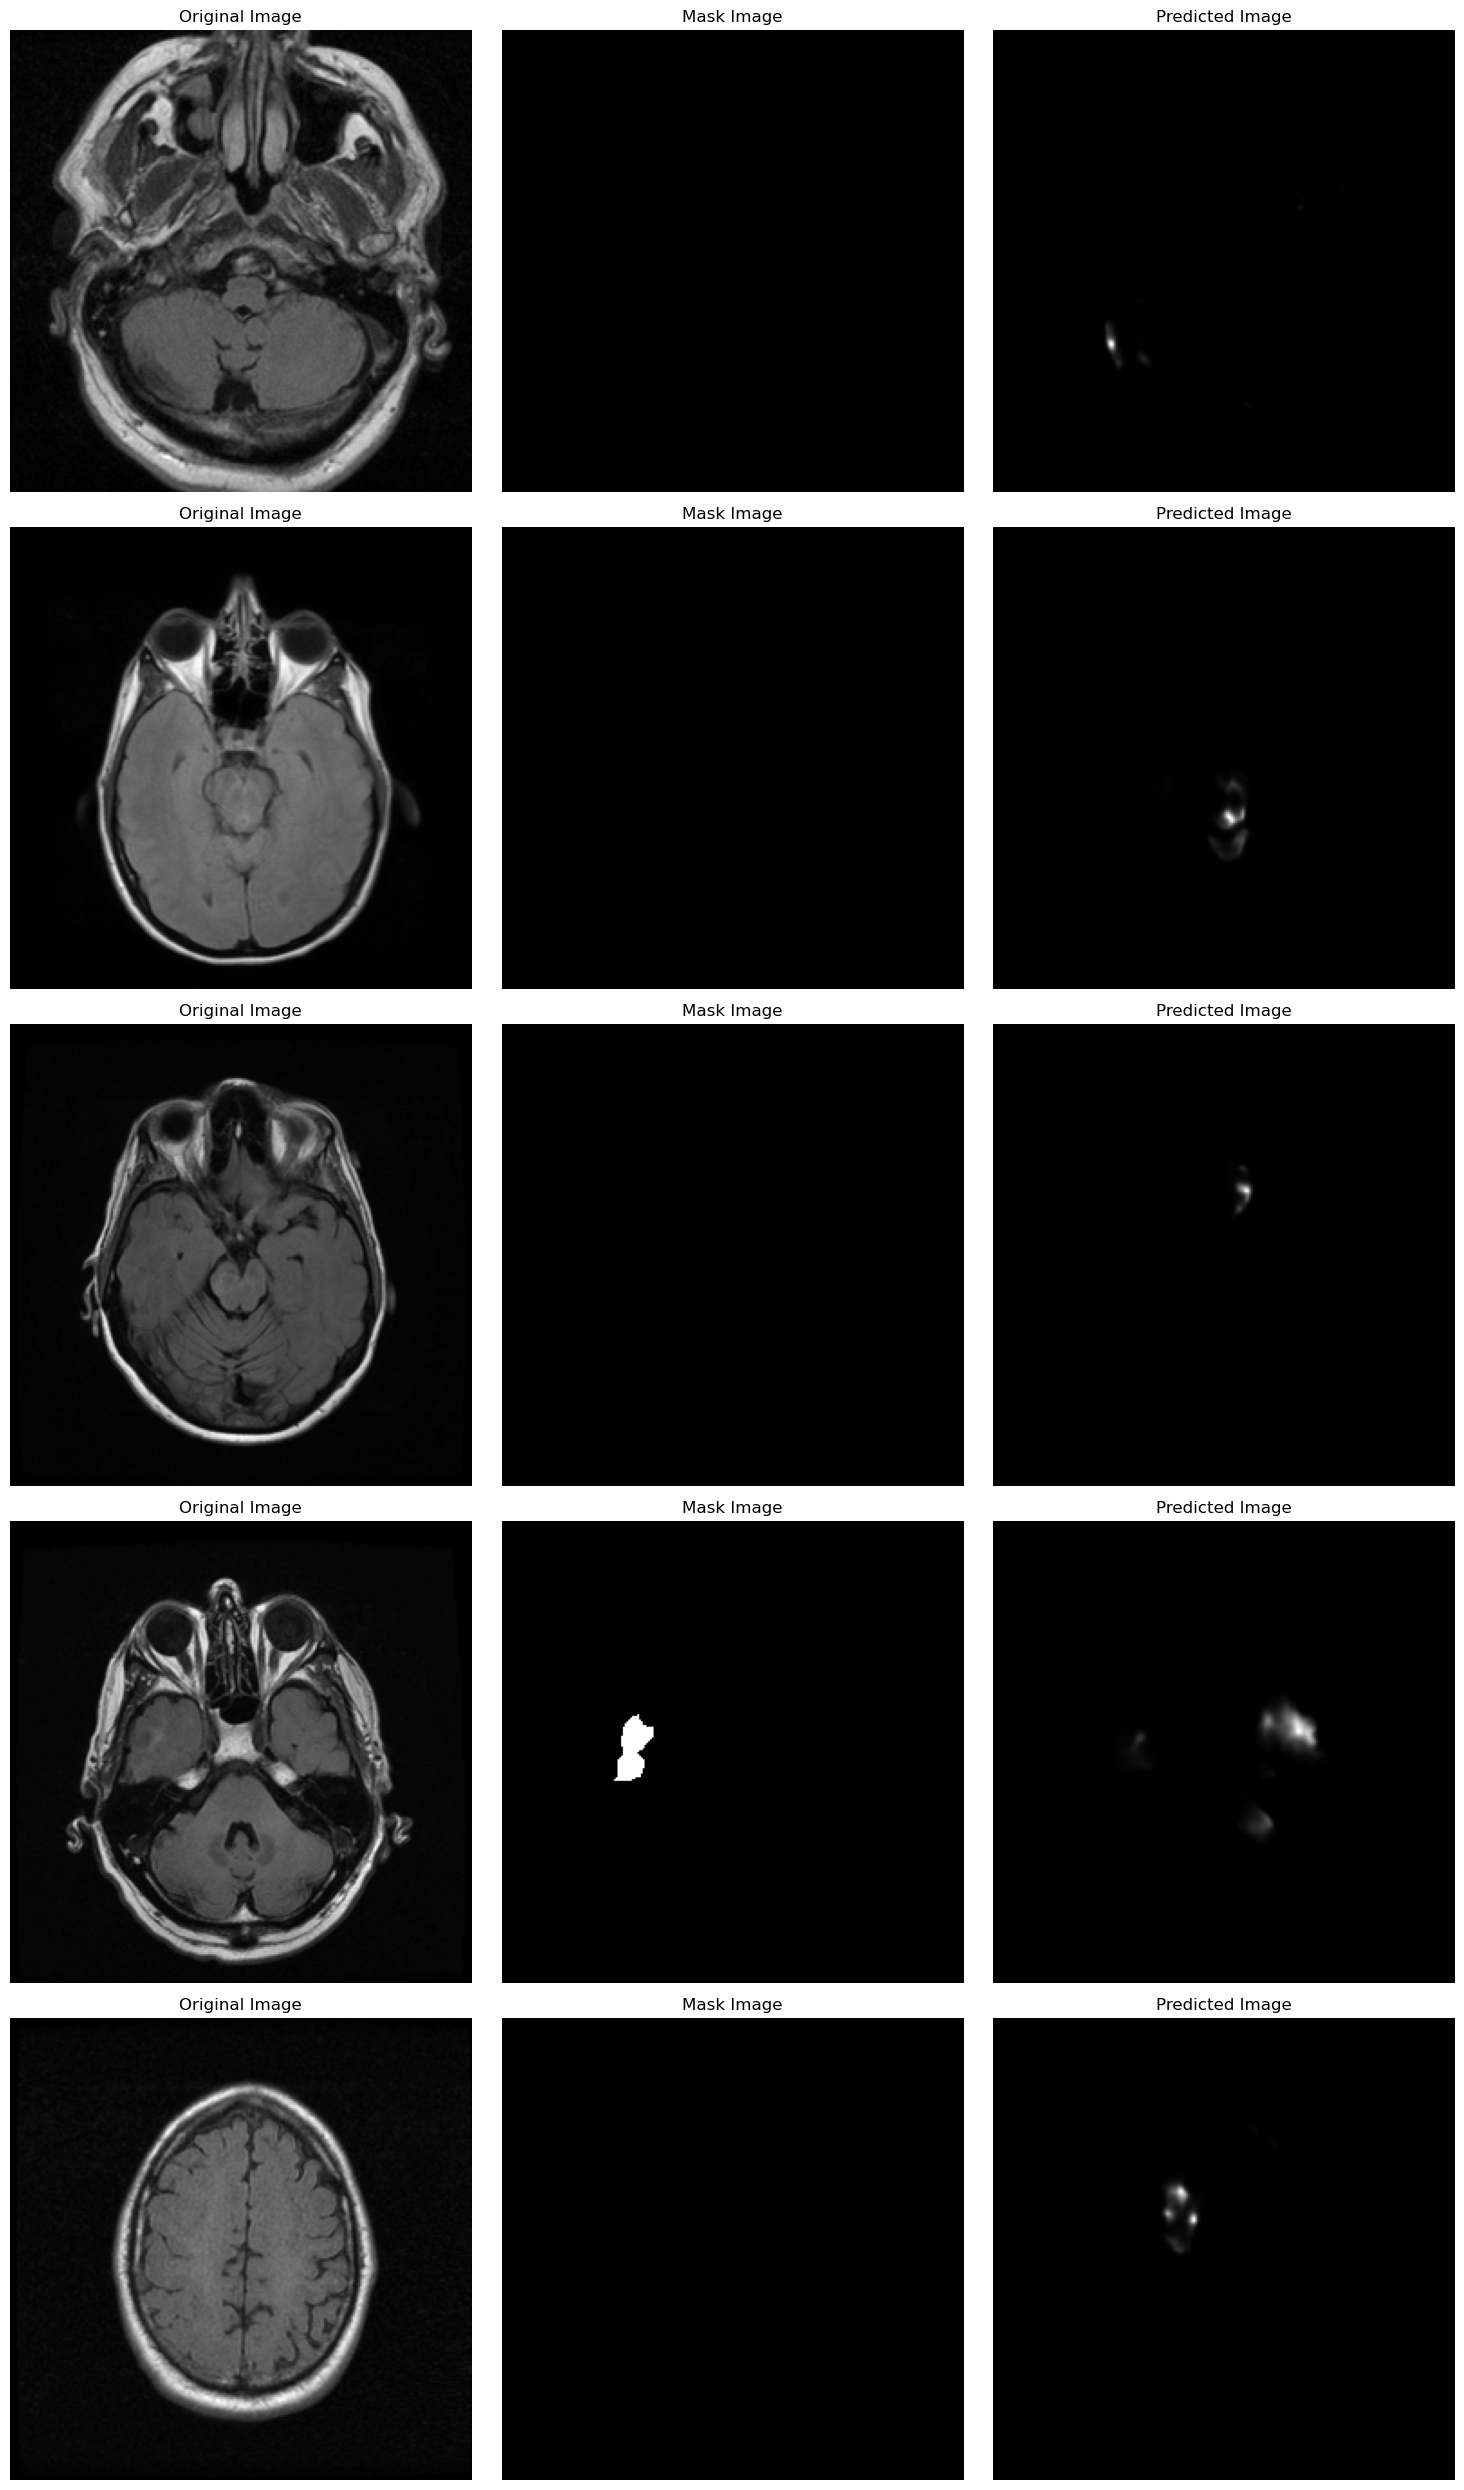

In [ ]:
# Display original, mask, and predicted images
def display_images(X, y, model, num_images=5):
    predictions = model.predict(X)
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(X[i].reshape(256, 256), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(y[i].reshape(256, 256), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
        plt.title('Predicted Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display images
display_images(X_test, y_test, model, num_images=5)

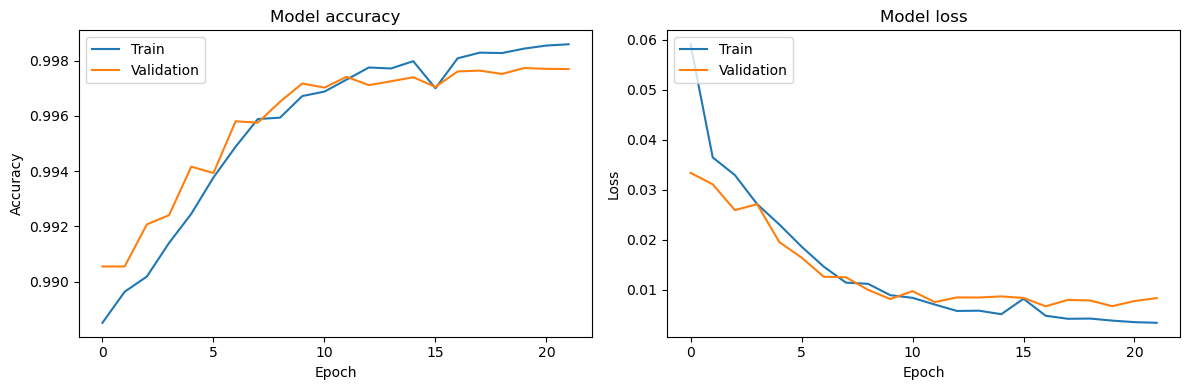

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step
Test Dice Score: 0.7804346084594727


In [ ]:
# Extracting the training history
history_dict = history.history

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Printing the results
print(f"Maximum Training Accuracy: {max_train_acc:.4f} at epoch {max_train_acc_epoch}")
print(f"Maximum Validation Accuracy: {max_val_acc:.4f} at epoch {max_val_acc_epoch}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at epoch {min_train_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at epoch {min_val_loss_epoch}")


Maximum Training Accuracy: 0.9986 at epoch 22
Maximum Validation Accuracy: 0.9977 at epoch 20
Minimum Training Loss: 0.0033 at epoch 22
Minimum Validation Loss: 0.0066 at epoch 17


In [ ]:
# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9971
Test Loss: 0.0092


In [ ]:
from sklearn.metrics import classification_report

# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten the arrays
y_test_flat = y_test.flatten().astype(int)
y_pred_flat = y_pred.flatten().astype(int)

# Calculate precision, recall, and F1-score
print(classification_report(y_test_flat, y_pred_flat))


19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  38246732
           1       0.87      0.86      0.86    419508

    accuracy                           1.00  38666240
   macro avg       0.94      0.93      0.93  38666240
weighted avg       1.00      1.00      1.00  38666240



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [ ]:
# Extracting the training history
history_dict = history.history

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Printing the results
print(f"Maximum Training Accuracy: {max_train_acc:.4f} at epoch {max_train_acc_epoch}")
print(f"Maximum Validation Accuracy: {max_val_acc:.4f} at epoch {max_val_acc_epoch}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at epoch {min_train_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at epoch {min_val_loss_epoch}")

Maximum Training Accuracy: 0.9986 at epoch 22
Maximum Validation Accuracy: 0.9977 at epoch 20
Minimum Training Loss: 0.0033 at epoch 22
Minimum Validation Loss: 0.0066 at epoch 17


In [ ]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step
Test Dice Score: 0.7804346084594727


In [ ]:
# Example Windows path:
root_dir = r"/home/surajit/Surajit-Dataset/kaggle_3m"

In [ ]:
import os, random, time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     concatenate, Activation, Add, multiply)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay)

In [ ]:
# Make TF deterministic-ish
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================
# STEP 3 — Data parameters
# ==========================
ROOT_DIR = r'/home/surajit/Surajit-Dataset/Segmentation-8'
TARGET_SIZE = (256, 256)         # H, W
PNG_EXT = '.png'
HARD_BINARY_MASK = True          # threshold masks to 0/1
RECURSIVE = False                # set True if you ever nest deeper than 1 level

# ======================================
# STEP 4 — Loader for same-folder PNGs
# ======================================
def is_mask_name(fname: str) -> bool:
    return fname.lower().endswith('_mask.png')

def find_mask_for_image(img_path: str) -> str | None:
    folder = os.path.dirname(img_path)
    base, _ = os.path.splitext(os.path.basename(img_path))
    if base.lower().endswith('_mask'):
        return None
    cand = os.path.join(folder, f'{base}_mask{PNG_EXT}')
    return cand if os.path.exists(cand) else None

def load_preprocess_image(img_path, target_size=TARGET_SIZE):
    img = load_img(img_path, color_mode='grayscale', target_size=target_size)
    img = img_to_array(img).astype('float32') / 255.0   # (H,W,1)
    return img

def load_preprocess_mask(mask_path, target_size=TARGET_SIZE, hard_binary=HARD_BINARY_MASK):
    mask = load_img(mask_path, color_mode='grayscale', target_size=target_size)
    mask = img_to_array(mask).astype('float32') / 255.0
    if hard_binary:
        mask = (mask > 0.5).astype('float32')           # 0/1
    return mask

def iter_image_files_one_level(root: str):
    paths = []
    for entry in os.scandir(root):
        if not entry.is_dir():
            continue
        sub = entry.path
        for f in os.listdir(sub):
            if f.lower().endswith(PNG_EXT) and not is_mask_name(f):
                paths.append(os.path.join(sub, f))
    return sorted(paths)

def iter_image_files_recursive(root: str):
    paths = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith(PNG_EXT) and not is_mask_name(f):
                paths.append(os.path.join(r, f))
    return sorted(paths)

def load_dataset_same_folder(root: str, target_size=TARGET_SIZE):
    if RECURSIVE:
        img_paths = iter_image_files_recursive(root)
    else:
        img_paths = iter_image_files_one_level(root)

    X, y, missing = [], [], []
    for img_path in img_paths:
        mask_path = find_mask_for_image(img_path)
        if mask_path is None:
            missing.append(img_path)
            continue
        X.append(load_preprocess_image(img_path, target_size))
        y.append(load_preprocess_mask(mask_path, target_size))

    if missing:
        print(f'[WARN] No mask found for {len(missing)} image(s). Example(s):')
        for p in missing[:5]:
            print('  -', p)

    X = np.stack(X, axis=0) if X else np.empty((0, *target_size, 1), dtype=np.float32)
    y = np.stack(y, axis=0) if y else np.empty((0, *target_size, 1), dtype=np.float32)
    return X, y

In [ ]:
X, y = load_dataset_same_folder(ROOT_DIR)

# Sanity check
assert X.shape == y.shape, "Images and masks should have the same shape."

# ===================================
# STEP 8 — Train/Val/Test split
# ===================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, shuffle=True
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (1534, 256, 256, 1) Val: (329, 256, 256, 1) Test: (329, 256, 256, 1)


In [ ]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Test Dice Score: 0.11203561723232269


In [ ]:
# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9824
Test Loss: 0.2233


11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step


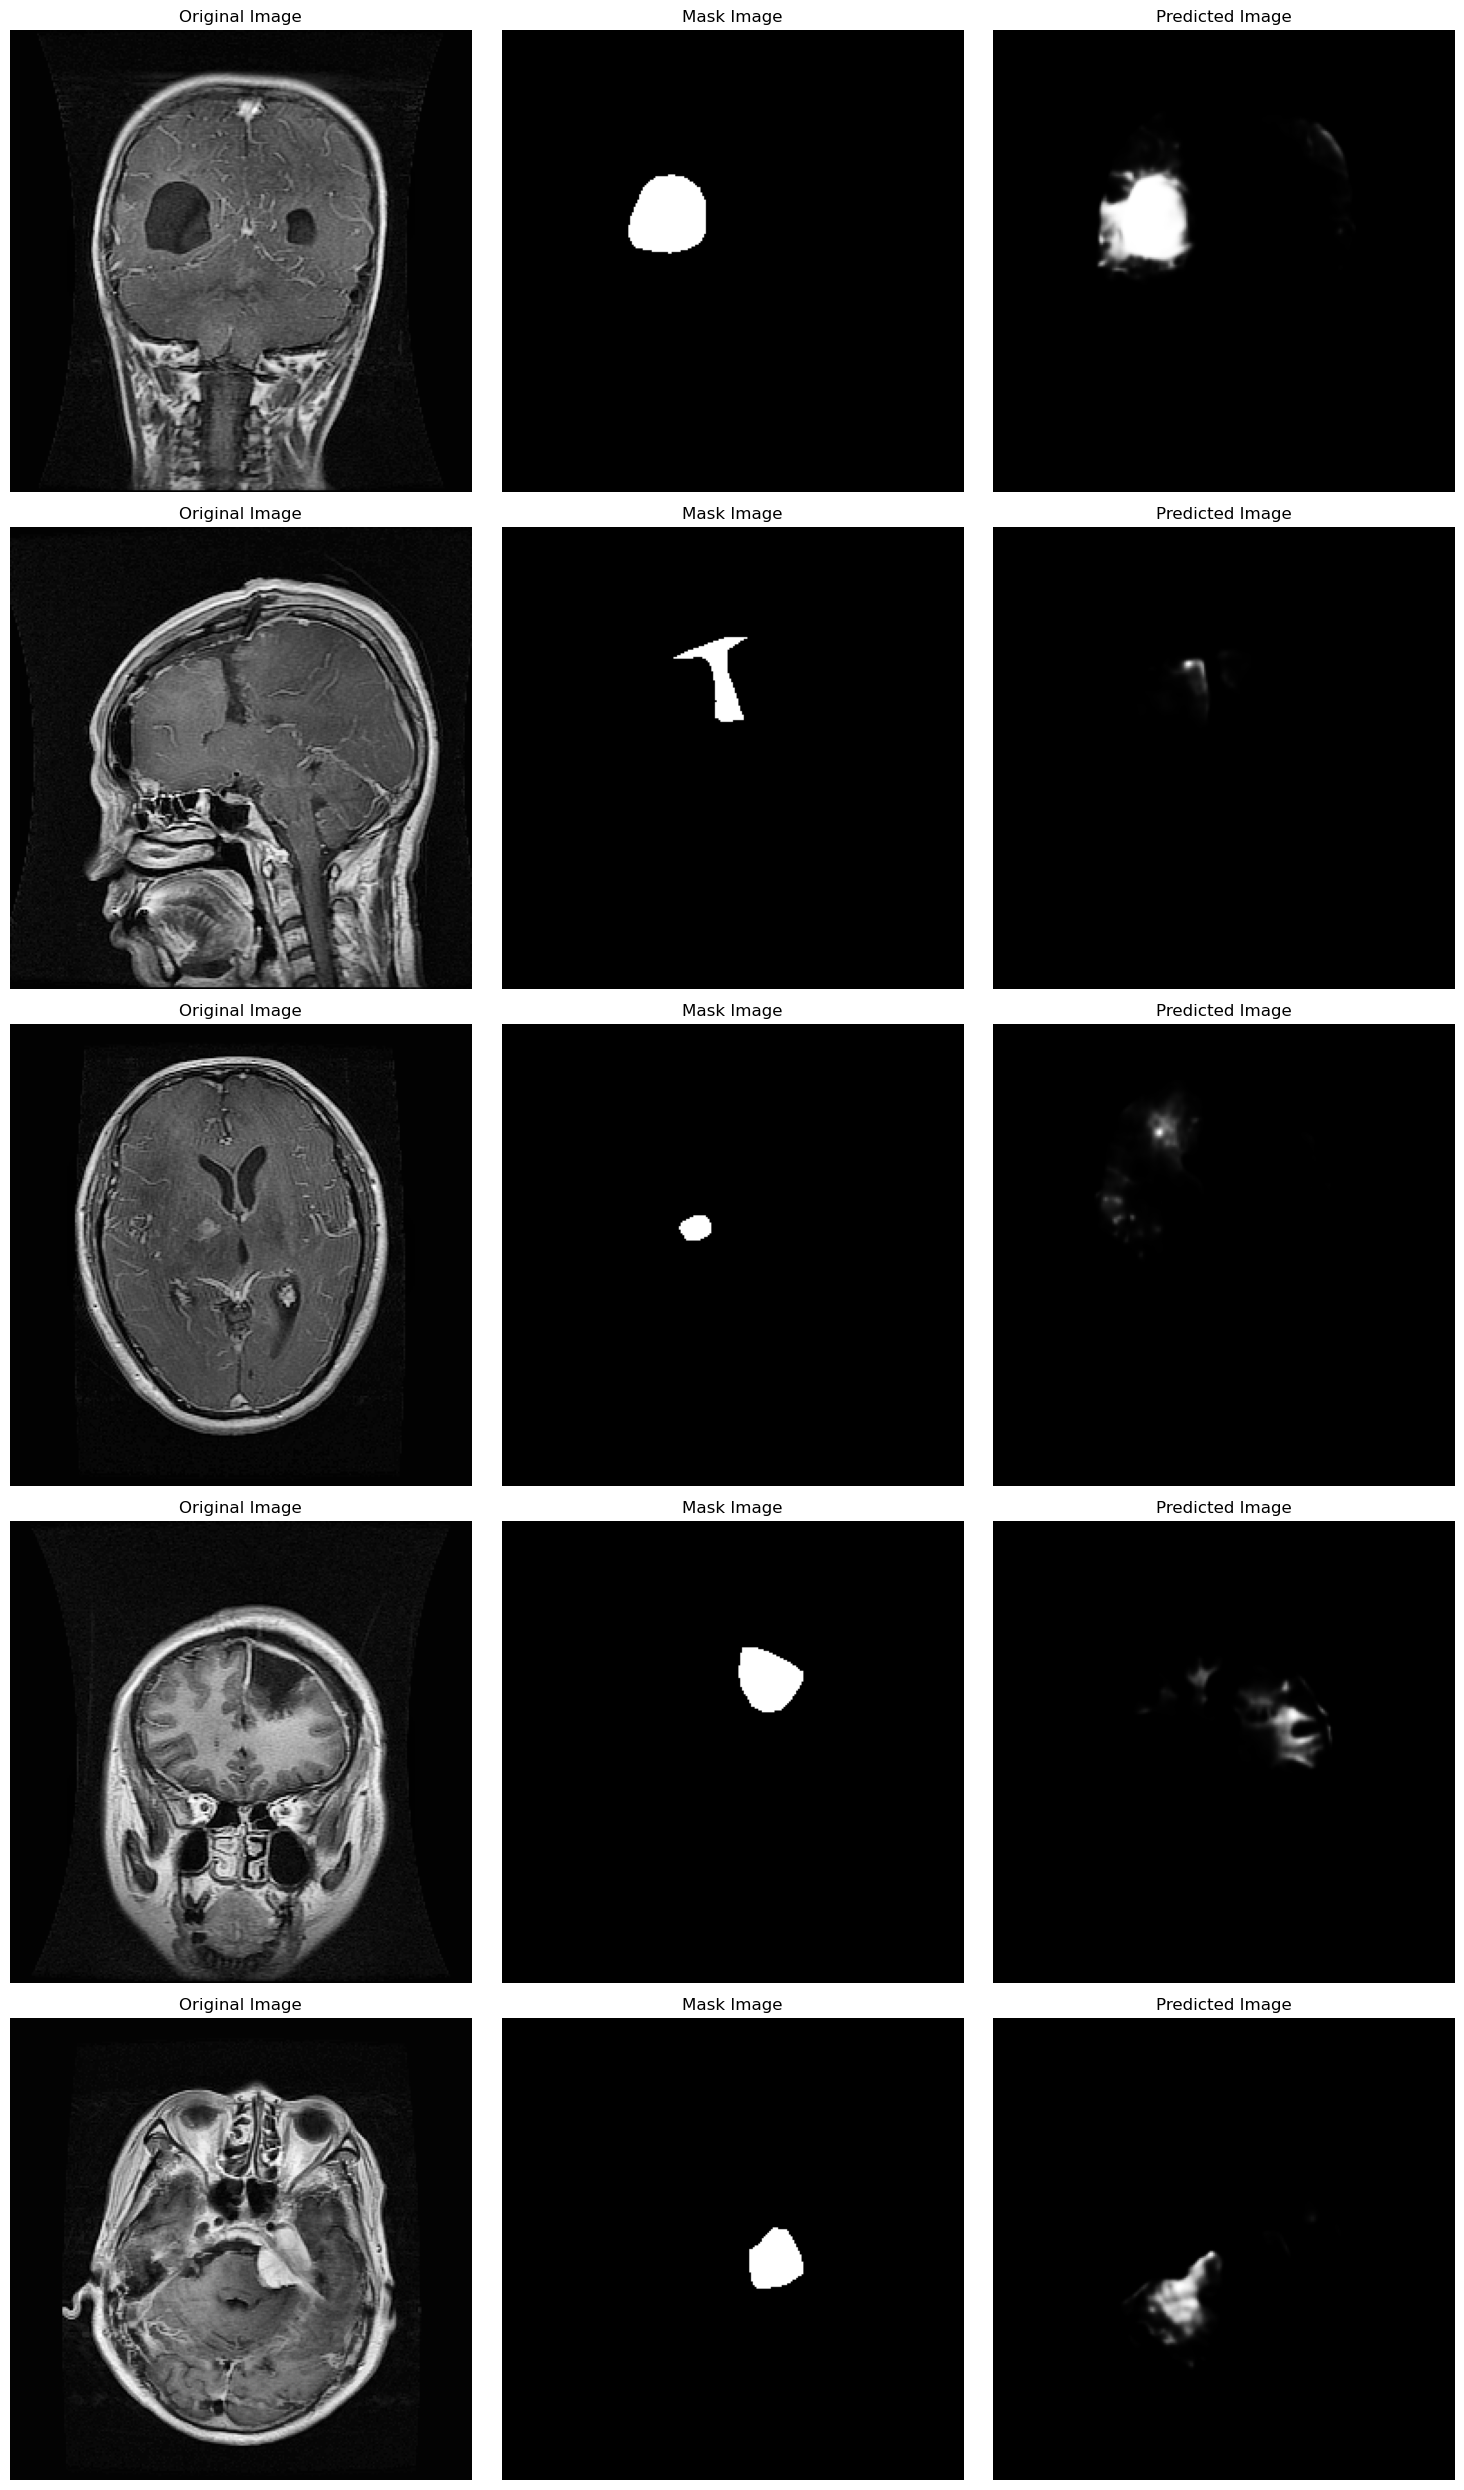

In [ ]:
# Display original, mask, and predicted images
def display_images(X, y, model, num_images=5):
    predictions = model.predict(X)
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(X[i].reshape(256, 256), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(y[i].reshape(256, 256), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
        plt.title('Predicted Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display images
display_images(X_test, y_test, model, num_images=5)

In [ ]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
Test Dice Score: 0.043049879372119904


Loaded 4237 images and 4237 masks.
Image shape: (256, 256, 3), Mask shape: (256, 256, 1)
Image data type: float32, Mask data type: float32
Image pixel range: 0.0 - 0.9647058844566345


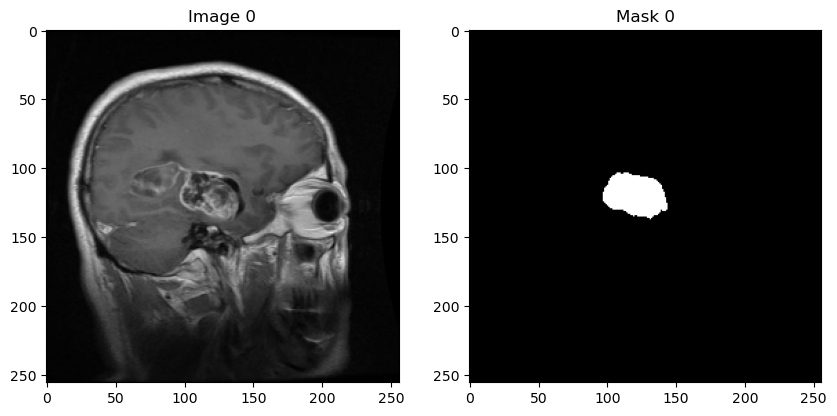

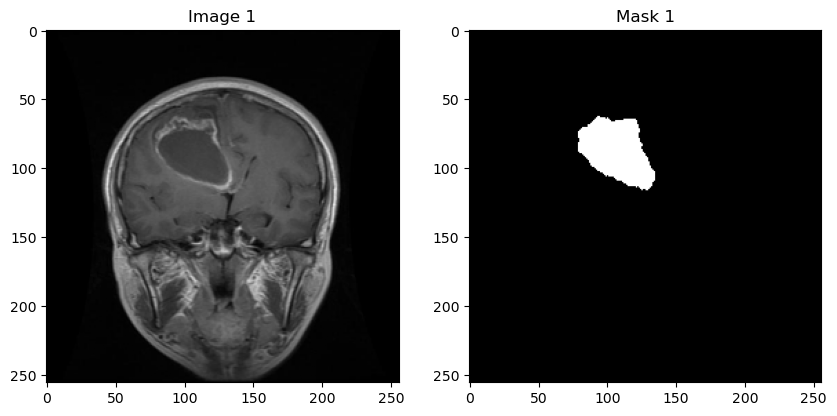

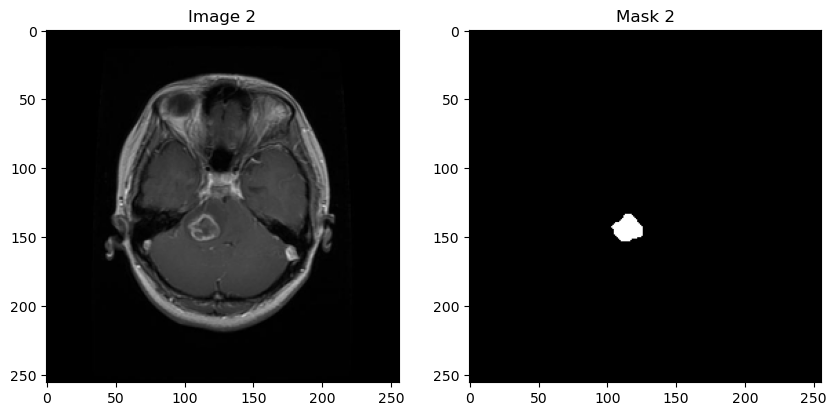

/home/surajit/anaconda3/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_12154/594776196.py:39: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
/tmp/ipykernel_12154/594776196.py:42: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  GaussNoise(var_limit=(5, 20), p=0.2)


Augmented 4237 images and 4237 masks.
Augmented Image shape: (256, 256, 3), Mask shape: (256, 256, 1)
Augmented Image data type: float32, Mask data type: float32
Augmented Image pixel range: 0.0 - 0.9647058844566345


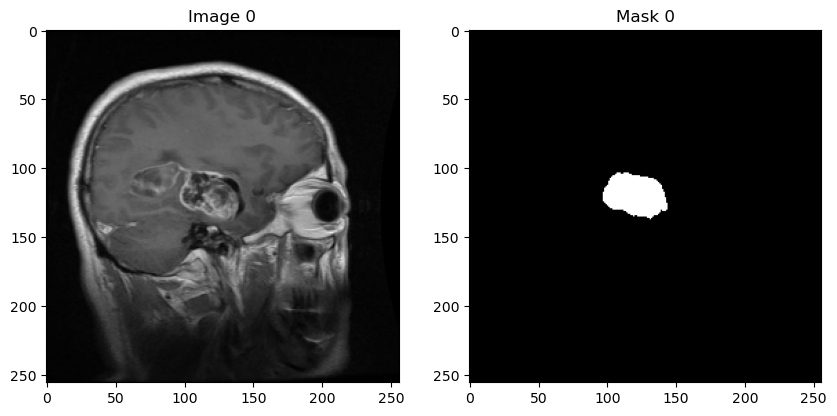

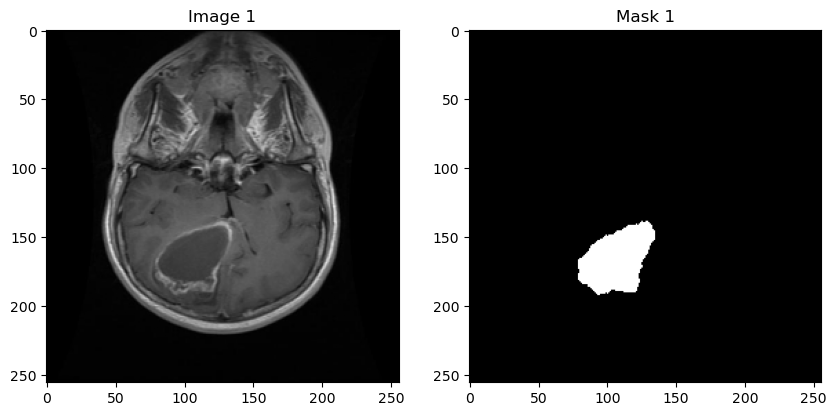

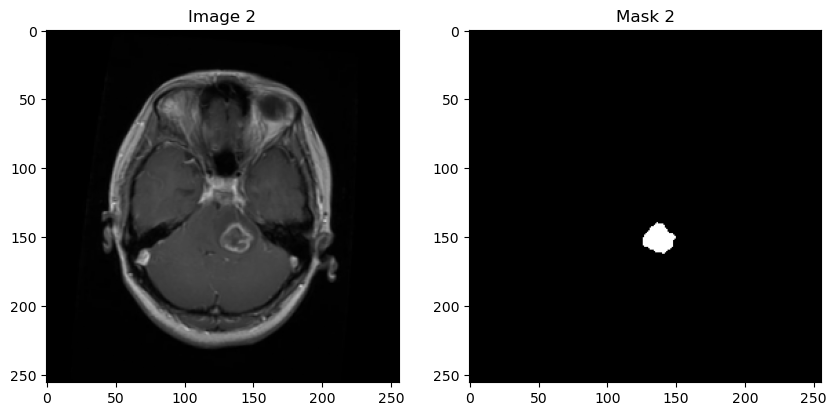

In [ ]:
import numpy as np
import os
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ElasticTransform,
    GridDistortion, CLAHE, GaussNoise, ShiftScaleRotate
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_dataset_with_augmentation(main_folder_path, augment=False):
    def load_preprocess_image(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error loading image: {image_path}")
            return None
        image = cv2.resize(image, (256, 256))  # Resize to match model input
        image = image / 255.0  # Normalize to [0, 1]
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=-1)  # Convert to RGB
        return image.astype(np.float32)  # Ensure type is float32

    def load_preprocess_mask(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Error loading mask: {mask_path}")
            return None
        mask = cv2.resize(mask, (256, 256))  # Resize to match model input
        mask = mask / 255.0  # Normalize to [0, 1]
        mask = (mask > 0.5).astype(np.float32)  # Binarize
        return np.expand_dims(mask, axis=-1)

    def augment_image_and_mask(image, mask):
        augmentation = Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RandomRotate90(p=0.5),
            ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
            ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
            GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
            GaussNoise(var_limit=(5, 20), p=0.2)
        ])
        augmented = augmentation(image=image, mask=mask)
        return augmented['image'], augmented['mask']

    image_folder = os.path.join(main_folder_path, "image")
    mask_folder = os.path.join(main_folder_path, "mask")

    X, y = [], []

    for subfolder in os.listdir(image_folder):
        image_subfolder_path = os.path.join(image_folder, subfolder)
        mask_subfolder_path = os.path.join(mask_folder, subfolder)

        if os.path.isdir(image_subfolder_path) and os.path.isdir(mask_subfolder_path):
            for file_name in os.listdir(image_subfolder_path):
                if file_name.endswith('.jpg'):  # Adjust extension if needed
                    base_name = file_name.replace('.jpg', '')
                    mask_name = f"{base_name}_m.jpg"
                    image_path = os.path.join(image_subfolder_path, file_name)
                    mask_path = os.path.join(mask_subfolder_path, mask_name)

                    if os.path.exists(image_path) and os.path.exists(mask_path):
                        image = load_preprocess_image(image_path)
                        mask = load_preprocess_mask(mask_path)

                        if image is None or mask is None:
                            continue

                        if augment:
                            image, mask = augment_image_and_mask(image, mask)

                        X.append(image)
                        y.append(mask)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def visualize_samples(X, y, num_samples=5):
    """Visualize a few samples from the dataset."""
    for i in range(min(num_samples, len(X))):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Image {i}")
        plt.imshow(X[i].astype('float32'), cmap='gray')  # Correct scaling for display
        plt.subplot(1, 2, 2)
        plt.title(f"Mask {i}")
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.show()

# Main folder path
main_folder_path = r'/home/surajit/Surajit-Dataset/6-Brain Tumor Segmentation Dataset'

# Load dataset without augmentation
X, y = load_dataset_with_augmentation(main_folder_path, augment=False)

# Debugging output
print(f"Loaded {len(X)} images and {len(y)} masks.")
if len(X) > 0:
    print(f"Image shape: {X[0].shape}, Mask shape: {y[0].shape}")
    print(f"Image data type: {X[0].dtype}, Mask data type: {y[0].dtype}")
    print(f"Image pixel range: {X[0].min()} - {X[0].max()}")

# Visualize samples
visualize_samples(X, y, num_samples=3)

# Load dataset with augmentation
X_aug, y_aug = load_dataset_with_augmentation(main_folder_path, augment=True)

# Debugging output
print(f"Augmented {len(X_aug)} images and {len(y_aug)} masks.")
if len(X_aug) > 0:
    print(f"Augmented Image shape: {X_aug[0].shape}, Mask shape: {y_aug[0].shape}")
    print(f"Augmented Image data type: {X_aug[0].dtype}, Mask data type: {y_aug[0].dtype}")
    print(f"Augmented Image pixel range: {X_aug[0].min()} - {X_aug[0].max()}")

# Visualize augmented samples
visualize_samples(X_aug, y_aug, num_samples=3)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import os
import random
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ElasticTransform,
    GridDistortion, CLAHE, GaussNoise, ShiftScaleRotate
)

# =============================
# STEP 1 — Make TF deterministic-ish
# =============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# =============================
# STEP 2 — Data parameters
# =============================
ROOT_DIR =  r'/home/surajit/Surajit-Dataset/6-Brain Tumor Segmentation Dataset'
TARGET_SIZE = (256, 256)   # H, W
IMG_EXT = '.jpg'
MASK_SUFFIX = '_m.jpg'
HARD_BINARY_MASK = True
AUGMENT = False   # set True if you want augmentations

# =============================
# STEP 3 — Loader functions
# =============================
def load_preprocess_image(img_path, target_size=TARGET_SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Error loading image: {img_path}")
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=-1)   # (H, W, 1)

def load_preprocess_mask(mask_path, target_size=TARGET_SIZE, hard_binary=HARD_BINARY_MASK):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Error loading mask: {mask_path}")
    mask = cv2.resize(mask, target_size)
    mask = mask.astype('float32') / 255.0
    if hard_binary:
        mask = (mask > 0.5).astype('float32')
    return np.expand_dims(mask, axis=-1)  # (H, W, 1)

def augment_image_and_mask(image, mask):
    augmentation = Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
        ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
        GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
        CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
        GaussNoise(var_limit=(5, 20), p=0.2)
    ])
    augmented = augmentation(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# =============================
# STEP 4 — Dataset loader
# =============================
def load_dataset(root: str, augment=AUGMENT):
    image_folder = os.path.join(root, "image")
    mask_folder = os.path.join(root, "mask")

    X, y, missing = [], [], []

    for subfolder in os.listdir(image_folder):
        image_subfolder = os.path.join(image_folder, subfolder)
        mask_subfolder = os.path.join(mask_folder, subfolder)

        if not (os.path.isdir(image_subfolder) and os.path.isdir(mask_subfolder)):
            continue

        for fname in os.listdir(image_subfolder):
            if not fname.endswith(IMG_EXT):
                continue

            base = fname.replace(IMG_EXT, "")
            mask_name = f"{base}{MASK_SUFFIX}"
            img_path = os.path.join(image_subfolder, fname)
            mask_path = os.path.join(mask_subfolder, mask_name)

            if not os.path.exists(mask_path):
                missing.append(img_path)
                continue

            img = load_preprocess_image(img_path, TARGET_SIZE)
            mask = load_preprocess_mask(mask_path, TARGET_SIZE)

            if augment:
                img, mask = augment_image_and_mask(img, mask)

            X.append(img)
            y.append(mask)

    if missing:
        print(f"[WARN] No mask found for {len(missing)} image(s). Example(s):")
        for p in missing[:5]:
            print("  -", p)

    X = np.stack(X, axis=0) if X else np.empty((0, *TARGET_SIZE, 1), dtype=np.float32)
    y = np.stack(y, axis=0) if y else np.empty((0, *TARGET_SIZE, 1), dtype=np.float32)
    return X, y

# =============================
# STEP 5 — Load and Split Dataset
# =============================
X, y = load_dataset(ROOT_DIR, augment=False)

print("Dataset loaded:", X.shape, y.shape)

# Sanity check
assert X.shape == y.shape, "Images and masks should have the same shape."

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, shuffle=True
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Dataset loaded: (4237, 256, 256, 1) (4237, 256, 256, 1)
Train: (2965, 256, 256, 1) Val: (636, 256, 256, 1) Test: (636, 256, 256, 1)


In [ ]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
Test Dice Score: 0.1353272795677185


In [ ]:
# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9885
Test Loss: 0.0784
